In [333]:
# General libraries which would be needed for this project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import calendar
from dateutil import parser
# get rid of warnings
import warnings
warnings.filterwarnings("ignore")

# Display to print all the columns of dataframes.
pd.set_option('display.max_columns', 500)

# import all the required libraries for modeling.
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [293]:
# read the file into datframe and print the few rows: engagement
engagement = pd.read_csv("takehome_user_engagement.csv")
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [294]:
# check basic info on columns and datatype.
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [295]:
# cahnge the data type of the time_stamp column
engagement['time_stamp'] = pd.to_datetime(engagement.time_stamp)

In [296]:
engagement[['time_stamp']].info() # to make sure that the dtype has changed for time_stamp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 1 columns):
time_stamp    207917 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.6 MB


In [297]:
# read the user file into dataframe: users
users = pd.read_csv("takehome_users.csv", encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [298]:
# basic info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [301]:
print("The number of unique users",engagement.user_id.nunique())

The number of unique users 8823


In [299]:
# convert the two data column from object time to datetime, and create time_difference column
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],
                                                         unit='s')
users['creation_time'] = pd.to_datetime(users.creation_time)
users['time_difference'] = (users['last_session_creation_time'].sub(users['creation_time'],
                                                                 axis=0))/ np.timedelta64(1, 'D')

**Users** dataframe's **object_id** is the **user_id** of the **engagement** dataframe. We need this when we join these two dataframe. **last_seesion_creation_time** in users dataframe has the equal number of row as of unique user_id of the engagement dataframe.<br>

Let's start with week period of each date time stamp in engagement dataset.

In [302]:
# add column 'week_stamp' in the dataset
engagement['week_stamp'] = engagement['time_stamp'].dt.to_period('1W')

In [303]:
# create a new dataframe grouped by userid and week_stamp: df1
# this will also list out the number of logins in a particular week
df1 = engagement.groupby(['user_id','week_stamp']).size().max(level=0).to_frame().reset_index()

In [304]:
# rename the column as weekly_login_count from 0
df1.rename(columns={0:'weekly_login_count'}, inplace=True)

In [305]:
# add column 'adopted_user' to df1 dataframe its value will be 1 if the weekly_login_count is 
# greater than 3, as per problem statement.
df1['adopted_user'] = np.where(df1['weekly_login_count']>=3, int(1), int(0))

In [306]:
# print the few records of the dataframe
df1.head()

,user_id,weekly_login_count,adopted_user
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


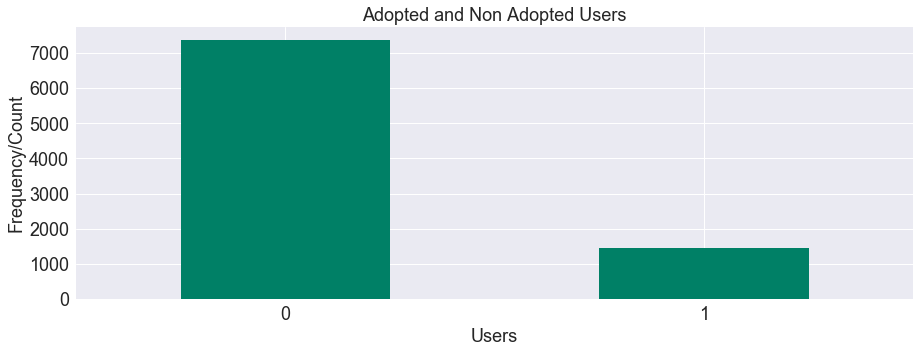

There are only 16.38% of adopted users!


In [307]:
# plot the number of adopted and non adopted users
df1['adopted_user'].value_counts().plot(kind='bar', figsize=(15,5), rot=360, fontsize=18, 
                                        colormap='summer')
plt.title("Adopted and Non Adopted Users",fontsize=18 )
plt.xlabel("Users", fontsize=18)
plt.ylabel('Frequency/Count', fontsize=18)
plt.show()

adpt = 100*df1.adopted_user.sum()/df1.adopted_user.count()
print("There are only {}% of adopted users!".format(round(adpt,2)))

As we can see above that there are only **16.38%** of adopted users are available. This makes our dataset **imbalanced** and we have to consider this fact before modeling.<br>
Now we will merger the two datsets we have one with the aopted users and the other one with users details. Lets start by renaming the **object_id** column of the **users** dataset.

In [308]:
# rename column object_id as user_id, this will help merging the two dataframes into one.
users.rename(columns={'object_id':'user_id'}, inplace=True)

In [309]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_difference
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0


In [310]:
# merge the 2 dataframe: df_full
df_full = pd.merge(users, df1, on='user_id', how='left')

In [311]:
df_full.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_difference,weekly_login_count,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0,3.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0,1.0,0.0


In [312]:
# check basic info of all the columns and null values.
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
time_difference               8823 non-null float64
weekly_login_count            8823 non-null float64
adopted_user                  8823 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(4), object(3)
memory usage: 1.3+ MB


### Data cleaning and wrangling ###
As we can see there are some missing values in **adopted_users, weekly_login_count, invited_by_user_id**, **last_session_creation_time** and **time_difference**. First lets start with the filling all the missing values with most suitable values.

In [313]:
# fill missing values in the column adopted_user with 0.
df_full['adopted_user'] = df_full['adopted_user'].fillna(0, axis=0)

# fill missing values in the column weekly_login_count with 0.
df_full['weekly_login_count'] = df_full['weekly_login_count'].fillna(0, axis=0)

# fill missing values in the column time_difference with 0.
df_full['time_difference'] = df_full['time_difference'].fillna(0, axis=0)

# fill missing values of the column invited_by_user_id with 0, as there may be users who would have 
# subscribed for the product without any invitation.
df_full['invited_by_user_id'] = df_full['invited_by_user_id'].fillna(0, axis=0)

In [319]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
time_difference               12000 non-null float64
weekly_login_count            12000 non-null float64
adopted_user                  12000 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(4), object(3)
memory usage: 1.6+ MB


In [337]:
df_full['adopted_user'] = df_full['adopted_user'].apply(lambda x: int(x))

### Feature Engineering ###
In this section will convert all the features into a numerical values for prediction. Also we will take care of **last_session_creation_time** column which has some missing values. As we can see above there are few columns with dtype as "boject", we will drop most of them as these **name** and **email** don't contribute to the pridiction. Similarly there are some numerical values are also there which can be simplified by converting them into a binary number. Like **invited_by_user**, an user can be either invited by someone or not, in this column user's id doesn't make sense. <br>
**creation_source** can have only 5 values, so we will convert this column into categorical number using **OneHotEncoder**.

In [368]:
# columns to be deleted: drop_cols
drop_cols = ['user_id','creation_time','name','email','last_session_creation_time',
             'weekly_login_count']
df_full.drop(drop_cols, axis=1, inplace=True)

In [369]:
# convert the user's id into binary number, 1 if invited by user 0 otherwise.
df_full['invited_by_user_id'] = df_full['invited_by_user_id'].apply(lambda x: 1 if x!=0 else 0)

In [371]:
# create final dataframe with OneHotEncodet
final_df = pd.get_dummies(df_full, columns=['creation_source'])
final_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_difference,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,1,0.0,0,1,0,0,0,0
1,0,0,1,1,136.0,1,0,1,0,0,0
2,0,0,94,1,0.0,0,0,1,0,0,0
3,0,0,1,1,1.0,0,1,0,0,0,0
4,0,0,193,1,5.0,0,1,0,0,0,0


### Modeling ###
We have final dataframe with all the required features and target. will extract **target** and **predictors** into different dataset. and then will use **SMOTE** oversampling technique to address the **imbalanced data** with very low number of adopted users as miniority class.

In [372]:
# get the target column: target
target = final_df[['adopted_user']]

# get all the fetures in X_features
X_features = final_df.drop('adopted_user', axis=1)

In [373]:
# split the data into training and test data
x_train, x_test, y_train, y_test = train_test_split(X_features, target,test_size=.3,random_state=42,
                                                   stratify = final_df['adopted_user'])

In [374]:
# Resampling of training dataset: sm, X_train_sm, y_train_sm
sm = SMOTE(kind = "regular")
x_train_sm, y_train_sm = sm.fit_sample(x_train, y_train)

In [375]:
# just to make sure we have same number of rows after resampling.
x_train_sm.shape[0] , y_train_sm.shape[0], x_train.shape[0], y_train.shape[0]

(14776, 14776, 8400, 8400)

### Gradient Boosting Random Tree ###
Gradient boosting classifier produces much better rate than **Linear** and **RandomForest**. Hence I will use this model using **GridSearchCV** to find the best hyper parmameters.

In [376]:
# GridSearch for best hyper-parameters: gbc
param_grid = {'n_estimators': [5,10,100], 'max_depth':[1,5,10], 'learning_rate': [0.1,1]}
gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)

In [379]:
# train the model
gbc.fit(x_train_sm, y_train_sm)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 100], 'max_depth': [1, 5, 10], 'learning_rate': [0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [380]:
# print out the best parameters and best score on training data
print("Best Parameters:",gbc.best_params_)
print("Best Score:",gbc.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Score: 0.98206551164


In [381]:
# prediction using the model on test data: y_pred_gbc
y_pred_gbc = gbc.predict(x_test)

In [382]:
# confusion Matrix for the random forest model: cm_gbc
cm_gbc = confusion_matrix(y_test, y_pred_gbc)
print("The confusion matrix for Gradient Boosting:\n", cm_gbc)

The confusion matrix for Gradient Boosting:
 [[3113   54]
 [  39  394]]


From the confusion matrix we can conclude that the model was able to predict **97%** correct class. Which is great model.

In [383]:
# print classification report which has summary for precision, recall and f1 score.
print(classification_report(y_test, y_pred_gbc))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99      3167
          1       0.88      0.91      0.89       433

avg / total       0.97      0.97      0.97      3600



In [400]:
# print F1 score of gradient boosting: f1_score_gbc
f1_score_gbc = f1_score(y_test, y_pred_gbc)
print("The f1 score for the GradientBoosting model:", f1_score_gbc)

The f1 score for the GradientBoosting model: 0.894438138479


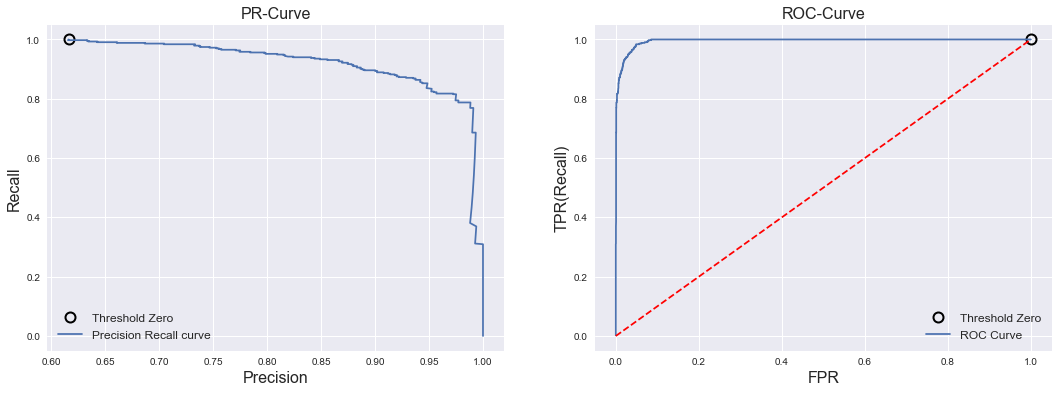

In [387]:
# calculate precision, recall and thresholds: 
precision, recall, thresholds_pr = precision_recall_curve(y_test, 
                                                        gbc.predict_proba(x_test)[:,1])
    
# find threshold close to 0 for PR (precision-recall): 
close_0_pr = np.argmin(np.abs(thresholds_pr))
    
# calculate fpr(flase positive rate), tpr(true positive rate) and thresholds: 
fpr, tpr, threshold_roc = roc_curve(y_test, gbc.predict_proba(x_test)[:,1])
    
# find threshold close to 0 for roc:
close_0_roc = np.argmin(np.abs(threshold_roc))
    
# plot PR-Curve
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.plot(precision[close_0_pr], recall[close_0_pr], 'o', 
         markersize=10, label="Threshold Zero",fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="Precision Recall curve")
plt.title("PR-Curve", fontsize=16)
plt.xlabel("Precision", fontsize=16)
plt.ylabel("Recall", fontsize=16)
plt.legend(loc="best", fontsize=12)
    
# plot ROC Curve
plt.subplot(1,2,2)
plt.plot(fpr[close_0_roc],tpr[close_0_roc],'o', markersize=10,label="Threshold Zero",
        fillstyle="none", c='k', mew=2)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC-Curve", fontsize=16)
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR(Recall)", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.show()

In [384]:
# features and their importance: feature_imp
feature_imp = gbc.best_estimator_.feature_importances_

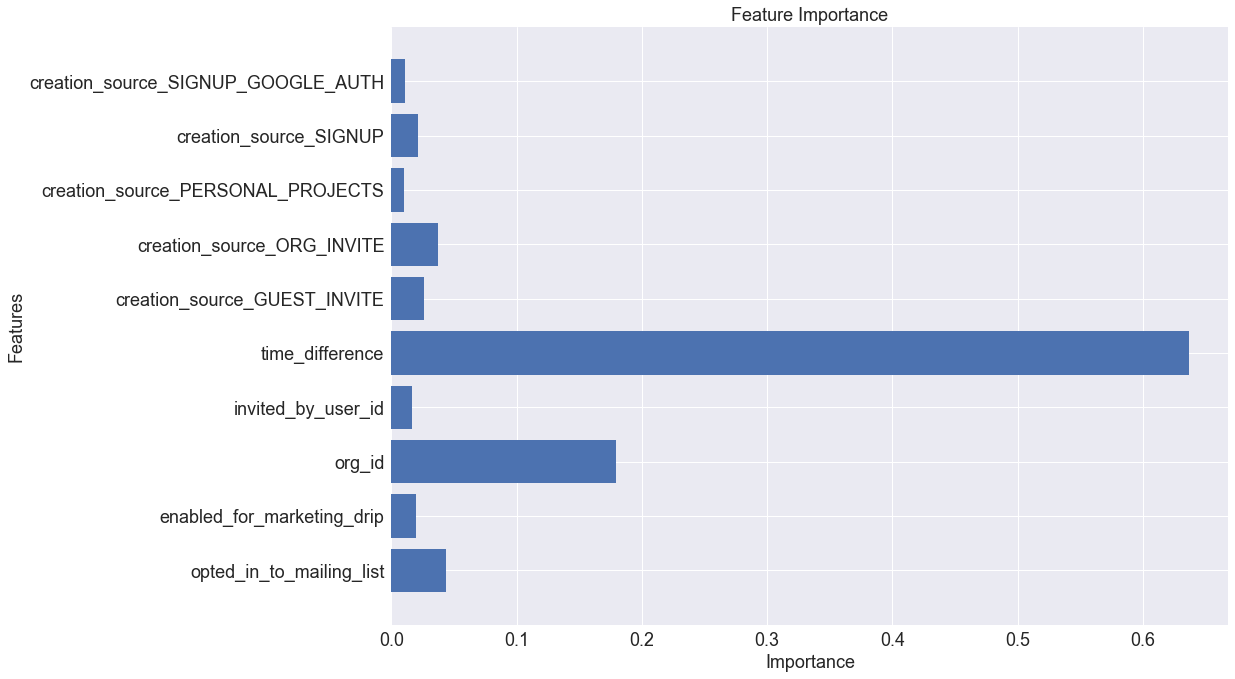

In [399]:
# Plot feature importance bar graph for better visualization.
n_features = x_train_sm.shape[1]
feature_names = X_features.columns
plt.figure(figsize=(15, 11))
plt.barh(range(n_features), feature_imp)
plt.yticks(np.arange(n_features), feature_names, fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.xlabel('Importance', fontsize=18)
plt.ylim(-1, n_features)
plt.title("Feature Importance", fontsize=18)
plt.show()

### Summary ###
As it can be seen from the above graph, that most of important feature in predicting user adoption is **"time_difference"** and this column was created using the **creation_time and last_session_creation_time**, also the organization they belong to is very crucial predictor, the other important predictor is if the users has opted for mailing list or not.

The model's performance has been evaluated using **Confusion Matrix**, **PR-Curve**, **F1-Score** and **ROC-curve**. The accuracy metric cann't be used for this model as the data we have is very imbalanced. As we can see from the ROC-Curve that the area uder curve(AUC) is very large, and the curve is very close to upper-left corner, which indicates a very good model.

The adoption rate is very low and company may want to dig deeper to find the reason or identify steps to improve the adoption rate.